In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# We are going to get a Convergence warning but want to ignore it 
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")
# Set random seed
np.random.RandomState(seed=42)

/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


RandomState(MT19937) at 0x11DD2B5A0

In [2]:
# Read in the dataset
full_df= pd.read_csv('Data/full_data_growth_included.csv', index_col=0)
full_df.head()

,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,walking gps hits,cases,deaths,Growth Rate,Num New Cases
0,Alabama,2020-03-13,7.0,32.0,26.0,7.0,-2.0,0.0,160.430000,110.95,110.84,6,0,NaN,NaN
1,Alabama,2020-03-14,1.0,28.0,55.0,12.0,4.0,0.0,169.976429,116.64,114.48,12,0,100.000000,6.0
2,Alabama,2020-03-15,-7.0,16.0,16.0,6.0,-4.0,2.0,119.303036,78.24,59.90,23,0,91.666667,11.0
3,Alabama,2020-03-16,-2.0,24.0,22.0,2.0,-10.0,4.0,116.498750,91.18,77.73,29,0,26.086957,6.0
4,Alabama,2020-03-17,-11.0,17.0,25.0,-1.0,-17.0,7.0,107.171250,84.92,72.97,39,0,34.482759,10.0


In [3]:
# Extract California dataset
ca= full_df[full_df['state'] == 'California']
ca.head()

,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,walking gps hits,cases,deaths,Growth Rate,Num New Cases
450,California,2020-02-15,1.0,1.0,19.0,1.0,-1.0,0.0,149.625000,98.747059,161.364286,7,0,0.0,0.0
451,California,2020-02-16,5.0,0.0,31.0,1.0,-1.0,-1.0,128.067973,85.542941,127.493810,7,0,0.0,0.0
452,California,2020-02-17,9.0,1.0,44.0,-12.0,-38.0,8.0,131.830676,98.512353,119.583333,7,0,0.0,0.0
453,California,2020-02-18,0.0,0.0,16.0,3.0,0.0,0.0,114.652568,110.847059,109.419524,7,0,0.0,0.0
454,California,2020-02-19,0.0,0.0,13.0,1.0,0.0,0.0,115.025946,110.649412,112.455238,7,0,0.0,0.0


In [4]:
ca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 450 to 581
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  132 non-null    object 
 1   date                   132 non-null    object 
 2   retail_and_recreation  132 non-null    float64
 3   grocery_and_pharmacy   132 non-null    float64
 4   parks                  132 non-null    float64
 5   transit                132 non-null    float64
 6   workplace              132 non-null    float64
 7   residential            132 non-null    float64
 8   driving gps hits       132 non-null    float64
 9   transit gps hits       132 non-null    float64
 10  walking gps hits       132 non-null    float64
 11  cases                  132 non-null    int64  
 12  deaths                 132 non-null    int64  
 13  Growth Rate            132 non-null    float64
 14  Num New Cases          132 non-null    float64
dtypes: f

In [5]:
ca_start_date= ca.date.min()
ca_end_date= ca.date.max()
print('The California data starts on {} and runs through {}.'.format(ca_start_date, ca_end_date))

The California data starts on 2020-02-15 and runs through 2020-06-27.


### Vanilla Linear Regression

14 day Prediction Time

We will use our mobility markers to predict COVID-19 infection rate 14 days into the future 

In [6]:
# We will do a manual train and test split of the data. Because there are 132 days in the dataset I will use the first
# 118 days for training and then use the last 14 days for testing 
x_train= ca[:118].drop(columns=['state', 'date', 'cases', 'deaths', 'Growth Rate', 'Num New Cases'])
x_test= ca[118:].drop(columns=['state', 'date', 'cases', 'deaths', 'Growth Rate', 'Num New Cases'])
y_train= pd.DataFrame(ca['Num New Cases'][:118])
y_test= pd.DataFrame(ca['Num New Cases'][118:])

print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')
print('Our y variable will be {}.'.format(list(y_train.columns)))

Our X variables will be ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit', 'workplace', 'residential', 'driving gps hits', 'transit gps hits', 'walking gps hits'].


Our y variable will be ['Num New Cases'].


In [7]:
# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(118, 9)
(14, 9)
(118, 1)
(14, 1)


In [8]:
from sklearn.metrics import mean_absolute_error
linear= linear_model.LinearRegression()
linear.fit(x_train, y_train)
r2_train= linear.score(x_train, y_train)
r2_test= linear.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))

R2 TRAIN: 0.7750292849035303
R2 TEST: -1.2227800956307986


In [9]:
y_pred_train= linear.predict(x_train)
y_pred_test= linear.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))


MAE TRAIN: 362.26899913182297
MAE TEST: 1323.4864985461463


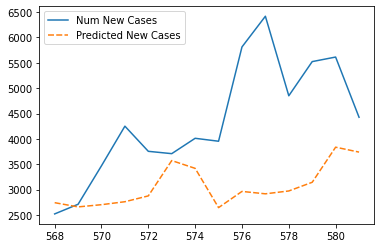

In [10]:
df= y_test.copy()
df['Predicted New Cases']= y_pred_test

sns.lineplot(data= df)


Text(0.5, 1.0, 'Residual Plot')

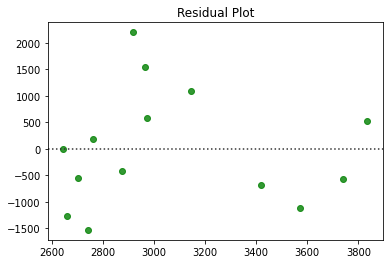

In [11]:
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot')

### Tackiling the Overfitting

Our model is performing rather poorly and severley overfitting the data so we will try to address the problem with either Lasso or Ridge regression methods

In [12]:
# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Lasso Regression
Best MAE:  -536.6070435071376
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -535.6228540269042
Best Params:  {'alpha': 1}


ElasticNet
Best MAE:  -527.450307305741
Best Params:  {'alpha': 0.1}


/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
# Lasso had best score so we will now see if it addresses the overfitting
lasso= linear_model.Lasso(alpha= 5)
lasso.fit(x_train, y_train)
r2_train= lasso.score(x_train, y_train)
r2_test= lasso.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))

R2 TRAIN: 0.7746398468590949
R2 TEST: -1.3267812814299025


In [14]:
y_pred_train= lasso.predict(x_train)
y_pred_test= lasso.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

# Lasso does not appear to address the overfitting problem and our model is still performing poorly 

MAE TRAIN: 363.5990230274704
MAE TEST: 1365.1038054072258


### Introducing Lagging Variables

In [15]:
lagged_df= ca.copy()

#Add a 14 and 7 day lag for target variable
# Add a 14 day lag for num new cases
lagged_df['Num_New_Cases_14_avg']= lagged_df['Num New Cases'].rolling(14).mean()

# Add a 7 day lag for num new cases
lagged_df['Num_New_Cases_7_avg']= lagged_df['Num New Cases'].rolling(7).mean()


# Add 14 and 7 day rolling average for mobility markers
# Create a list of all the mobiity markers
mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

# Create a 14 days running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_14_avg'.format(marker)]= lagged_df[marker].rolling(14).mean()

# Create a 7 day running avergae for all mobility markers
for marker in mobility_markers:
    lagged_df['{}_7_avg'.format(marker)]= lagged_df[marker].rolling(7).mean()

In [16]:
lagged_df.head(16)

,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,...,walking gps hits_14_avg,retail_and_recreation_7_avg,grocery_and_pharmacy_7_avg,parks_7_avg,transit_7_avg,workplace_7_avg,residential_7_avg,driving gps hits_7_avg,transit gps hits_7_avg,walking gps hits_7_avg
450,California,2020-02-15,1.0,1.0,19.0,1.0,-1.0,0.0,149.625000,98.747059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,California,2020-02-16,5.0,0.0,31.0,1.0,-1.0,-1.0,128.067973,85.542941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452,California,2020-02-17,9.0,1.0,44.0,-12.0,-38.0,8.0,131.830676,98.512353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,California,2020-02-18,0.0,0.0,16.0,3.0,0.0,0.0,114.652568,110.847059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
454,California,2020-02-19,0.0,0.0,13.0,1.0,0.0,0.0,115.025946,110.649412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,California,2020-02-20,2.0,1.0,12.0,1.0,0.0,0.0,120.621216,108.973529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456,California,2020-02-21,1.0,0.0,8.0,0.0,1.0,0.0,143.535541,117.529412,...,NaN,2.571429,0.428571,20.428571,-0.714286,-5.571429,1.000000,129.051274,104.400252,126.339864
457,California,2020-02-22,0.0,0.0,-3.0,-4.0,1.0,1.0,142.735676,97.484118,...,NaN,2.428571,0.285714,17.285714,-1.428571,-5.285714,1.142857,128.067085,104.219832,125.218639
458,California,2020-02-23,4.0,1.0,16.0,3.0,2.0,0.0,119.011486,88.245294,...,NaN,2.285714,0.428571,15.142857,-1.142857,-4.857143,1.285714,126.773301,104.605882,123.118707
459,California,2020-02-24,2.0,0.0,12.0,1.0,4.0,0.0,111.661351,109.474706,...,NaN,1.285714,0.285714,10.571429,0.714286,1.142857,0.142857,123.891969,106.171933,121.521633


In [17]:
lagged_df.tail()

,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,...,walking gps hits_14_avg,retail_and_recreation_7_avg,grocery_and_pharmacy_7_avg,parks_7_avg,transit_7_avg,workplace_7_avg,residential_7_avg,driving gps hits_7_avg,transit gps hits_7_avg,walking gps hits_7_avg
577,California,2020-06-23,-29.0,-7.0,14.0,-38.0,-42.0,14.0,142.186081,48.518235,...,138.222857,-29.714286,-5.142857,9.714286,-37.000000,-33.428571,11.285714,149.188050,47.389916,140.566871
578,California,2020-06-24,-29.0,-8.0,9.0,-39.0,-41.0,14.0,146.346757,51.071176,...,139.140170,-29.714286,-5.428571,9.285714,-37.142857,-33.428571,11.285714,150.375695,47.750840,141.536190
579,California,2020-06-25,-29.0,-7.0,7.0,-39.0,-41.0,14.0,153.047703,51.350588,...,140.506088,-29.857143,-5.714286,9.000000,-37.142857,-33.428571,11.285714,151.613436,47.960924,143.035578
580,California,2020-06-26,-31.0,-7.0,7.0,-39.0,-40.0,14.0,177.028378,53.797059,...,141.782585,-30.000000,-6.142857,8.714286,-37.285714,-33.428571,11.571429,152.733687,48.398487,143.923333
581,California,2020-06-27,-33.0,-6.0,6.0,-32.0,-16.0,7.0,176.721892,49.085882,...,142.681293,-30.285714,-7.142857,8.714286,-37.285714,-33.714286,11.571429,154.075251,48.893866,145.168299


In [18]:
lagged_df.columns

Index(['state', 'date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit', 'workplace', 'residential', 'driving gps hits',
       'transit gps hits', 'walking gps hits', 'cases', 'deaths',
       'Growth Rate', 'Num New Cases', 'Num_New_Cases_14_avg',
       'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg',
       'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg',
       'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg',
       'transit gps hits_14_avg', 'walking gps hits_14_avg',
       'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg',
       'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg',
       'driving gps hits_7_avg', 'transit gps hits_7_avg',
       'walking gps hits_7_avg'],
      dtype='object')

In [19]:
lagged_df.dropna(inplace=True)
len(lagged_df)

119

In [20]:
# We will do a manual train and test split of the data. Because there are 132 days in the dataset I will use the first
# 105 days for training and then use the last 14 days for testing 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-18:]
y= lagged_df['Num New Cases']
x_train= X[:105]
x_test= X[105:]
y_train= y[:105]
y_test= y[105:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Our X variables will be ['retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(105, 18)
(105,)
(14, 18)
(14,)


In [21]:
linear= linear_model.LinearRegression()
linear.fit(x_train, y_train)
r2_train= linear.score(x_train, y_train)
r2_test= linear.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))

R2 TRAIN: 0.83863799134425
R2 TEST: 0.2917352412330494


In [22]:
y_pred_train= linear.predict(x_train)
y_pred_test= linear.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

MAE TRAIN: 253.8804762193896
MAE TEST: 685.0419880545945


Text(0.5, 1.0, 'Residual Plot')

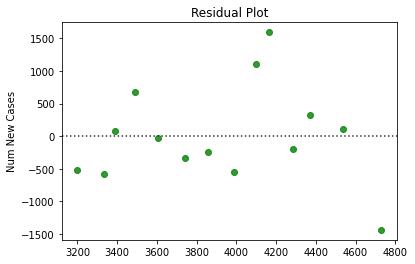

In [23]:
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot')

We are seeing better results using the lagging variables but are still seeing a lot of overfitting

### Lasso, Ridge, Elastic Net

In [24]:

# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Lasso Regression
Best MAE:  -556.3468425401409
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -522.0296442760731
Best Params:  {'alpha': 1}


ElasticNet
Best MAE:  -513.5697134187498
Best Params:  {'alpha': 0.1}


### Utilizing the lagging variables of the target cases

In [25]:
# We will do a manual train and test split of the data. Because there are 132 days in the dataset I will use the first
# 105 days for training and then use the last 14 days for testing 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']
x_train= X[:105]
x_test= X[105:]
y_train= y[:105]
y_test= y[105:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(105, 20)
(105,)
(14, 20)
(14,)


In [26]:
linear= linear_model.LinearRegression()
linear.fit(x_train, y_train)
r2_train= linear.score(x_train, y_train)
r2_test= linear.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))

R2 TRAIN: 0.8764034057689516
R2 TEST: 0.46357813685347415


In [27]:
y_pred_train= linear.predict(x_train)
y_pred_test= linear.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

MAE TRAIN: 243.42946023622093
MAE TEST: 654.5969425019039


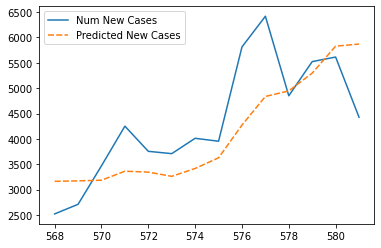

In [28]:
y_test_copy= y_test.copy()
df= y_test_copy.to_frame()



predicted= y_pred_test.tolist()

df['Predicted New Cases']= predicted


sns.lineplot(data= df)

Text(0.5, 1.0, 'Residual Plot')

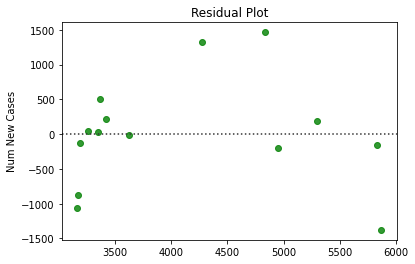

In [29]:
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot')

In [30]:
# Lasso
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.Lasso(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Lasso Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

# Ridge
grid= GridSearchCV(linear_model.Ridge(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('Ridge Regression')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('\n')

#ElasticNet
alpha= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid= dict(alpha= alpha)

grid= GridSearchCV(linear_model.ElasticNet(), param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result= grid.fit(x_train, y_train)

print('ElasticNet')
print('Best MAE: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Lasso Regression
Best MAE:  -333.5056855222046
Best Params:  {'alpha': 10}


Ridge Regression
Best MAE:  -318.0509165144125
Best Params:  {'alpha': 1}


ElasticNet
Best MAE:  -326.7751383739104
Best Params:  {'alpha': 0.01}


In [31]:
# Ridge had best score so we will now see if it addresses the overfitting
ridge= linear_model.Ridge(alpha= 1)
ridge.fit(x_train, y_train)
r2_train= ridge.score(x_train, y_train)
r2_test= ridge.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))

R2 TRAIN: 0.8603284216760025
R2 TEST: 0.5849763826468346


In [32]:
y_pred_train= ridge.predict(x_train)
y_pred_test= ridge.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

MAE TRAIN: 240.33416077477207
MAE TEST: 517.481746291632


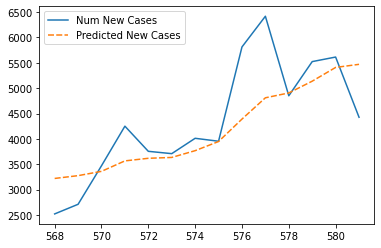

In [33]:
y_test_copy= y_test.copy()
df= y_test_copy.to_frame()



predicted= y_pred_test.tolist()

df['Predicted New Cases']= predicted


sns.lineplot(data= df)

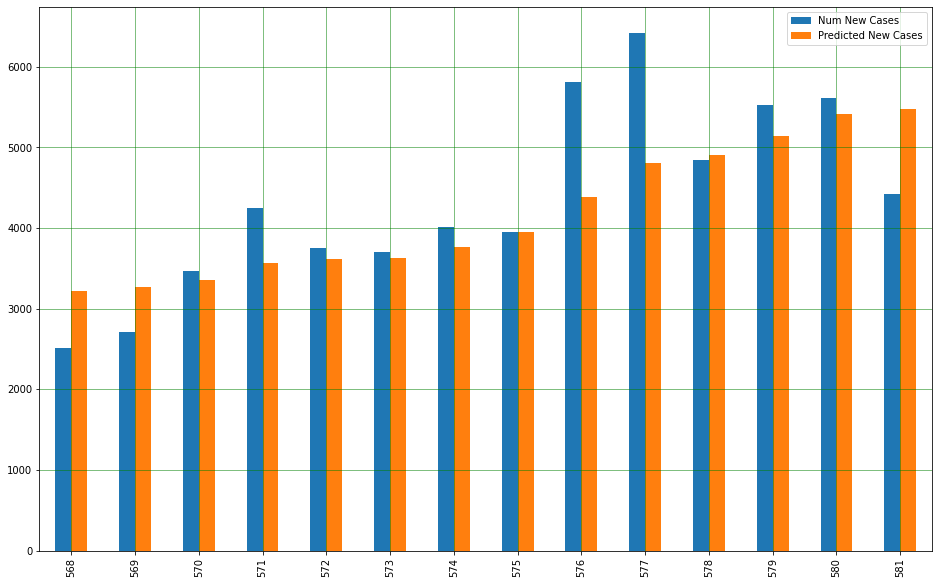

In [34]:
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Text(0.5, 1.0, 'Residual Plot')

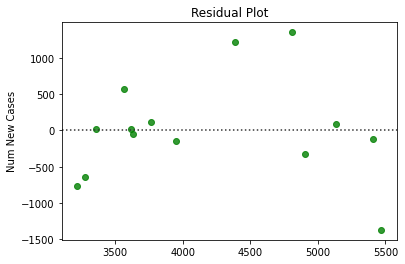

In [35]:
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot')

In [36]:
coeff_df = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])  
coeff_df.sort_values(by='Coefficient', ascending=False)

,Coefficient
Num_New_Cases_7_avg,796.137807
parks_7_avg,340.710968
residential_7_avg,290.295959
Num_New_Cases_14_avg,256.873812
transit gps hits_7_avg,193.211595
retail_and_recreation_14_avg,135.974464
retail_and_recreation_7_avg,135.484619
grocery_and_pharmacy_7_avg,105.368132
driving gps hits_14_avg,92.650709
residential_14_avg,64.935358


### Reducing the prediction window to 7 days

In [37]:
# We will do a manual train and test split of the data. Because there are 119 days in the dataset I will use the first
# 105 days for training and then use the last 14 days for testing 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']
x_train= X[:112]
x_test= X[112:]
y_train= y[:112]
y_test= y[112:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(112, 20)
(112,)
(7, 20)
(7,)


In [38]:
linear= linear_model.LinearRegression()
linear.fit(x_train, y_train)
r2_train= linear.score(x_train, y_train)
r2_test= linear.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))

R2 TRAIN: 0.8924367428298349
R2 TEST: -0.9625117061594813


In [39]:
y_pred_train= linear.predict(x_train)
y_pred_test= linear.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

MAE TRAIN: 253.62676269622474
MAE TEST: 938.4312064822492


### Random Forest Regressor

In [40]:
# We will do a manual train and test split of the data. Because there are 132 days in the dataset I will use the first
# 105 days for training and then use the last 14 days for testing 
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-20:]
y= lagged_df['Num New Cases']
x_train= X[:105]
x_test= X[105:]
y_train= y[:105]
y_test= y[105:]


print('Our X variables will be {}.'.format(list(x_train.columns)))
print('\n')

# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)


y_pred_test= rf.predict(x_test)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

Our X variables will be ['Num_New_Cases_14_avg', 'Num_New_Cases_7_avg', 'retail_and_recreation_14_avg', 'grocery_and_pharmacy_14_avg', 'parks_14_avg', 'transit_14_avg', 'workplace_14_avg', 'residential_14_avg', 'driving gps hits_14_avg', 'transit gps hits_14_avg', 'walking gps hits_14_avg', 'retail_and_recreation_7_avg', 'grocery_and_pharmacy_7_avg', 'parks_7_avg', 'transit_7_avg', 'workplace_7_avg', 'residential_7_avg', 'driving gps hits_7_avg', 'transit gps hits_7_avg', 'walking gps hits_7_avg'].


(105, 20)
(105,)
(14, 20)
(14,)
MAE TRAIN: 253.62676269622474
MAE TEST: 1304.5273571428572


In [41]:
importance= list(rf.feature_importances_)
variables= list(lagged_df.iloc[:,-18:].columns)

feature_importance= list(zip(variables, importance))
feature_importance.sort(key=lambda x:x[1], reverse=True)
feature_importance

[('grocery_and_pharmacy_14_avg', 0.48041913659899554),
 ('retail_and_recreation_14_avg', 0.27799747495377813),
 ('parks_14_avg', 0.023888159300832556),
 ('workplace_14_avg', 0.019911786512693968),
 ('retail_and_recreation_7_avg', 0.01765120027507965),
 ('transit_14_avg', 0.016178728210462262),
 ('workplace_7_avg', 0.015892585927282866),
 ('grocery_and_pharmacy_7_avg', 0.012886018626189679),
 ('parks_7_avg', 0.012175197176259655),
 ('transit gps hits_7_avg', 0.011565844802062882),
 ('driving gps hits_14_avg', 0.011535667820128033),
 ('residential_14_avg', 0.011517040919362776),
 ('transit_7_avg', 0.01084635122781443),
 ('walking gps hits_14_avg', 0.01076940335449762),
 ('walking gps hits_7_avg', 0.010454818660424877),
 ('residential_7_avg', 0.009869666907473446),
 ('driving gps hits_7_avg', 0.009621335734350612),
 ('transit gps hits_14_avg', 0.0095006542644925)]

In [42]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [43]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [45]:
# Instantiate model with 1400 decision trees
rf = RandomForestRegressor(n_estimators = 600, min_samples_split= 5, min_samples_leaf= 1, max_features= 'auto', max_depth=80, bootstrap=True, oob_score= True, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)


y_pred_test= rf.predict(x_test)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TEST: {}'.format(mae_test))

oob_score= rf.oob_score_
print('OOB Score: {}'.format(oob_score))

MAE TEST: 1216.2703800891563
OOB Score: 0.7841663604993723
